In [1]:
import os
import shutil
import glob
import cv2
import random
import pickle
from pickle import load
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display_html
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import load_model
from keras.constraints import max_norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sn
import datetime

Using TensorFlow backend.


>> Total training images:  25331   at:   /home/vasileiosaidonis/ISIC 2019/Training_Images
>> Total test images:      8238    at:   /home/vasileiosaidonis/ISIC 2019/Test_Images


,image,age_approx,anatom_site_general,lesion_id,sex,dx,label
23815,ISIC_0070853,60.0,anterior torso,BCN_0000152,male,BCC,1
1740,ISIC_0013227_downsampled,45.0,head/neck,MSK4_0011686,female,NV,5
1683,ISIC_0013127_downsampled,60.0,posterior torso,MSK4_0011609,female,BKL,2
1141,ISIC_0011171,30.0,anterior torso,NaN,female,NV,5
15601,ISIC_0057818,75.0,anterior torso,BCN_0004091,female,NV,5
22839,ISIC_0069293,65.0,head/neck,BCN_0001694,male,MEL,4
17090,ISIC_0060148,55.0,lower extremity,BCN_0002829,female,MEL,4
22259,ISIC_0068391,40.0,anterior torso,BCN_0000281,male,NV,5
11435,ISIC_0032838,45.0,anterior torso,HAM_0001264,male,NV,5
25077,ISIC_0072860,40.0,lower extremity,BCN_0004382,male,NV,5


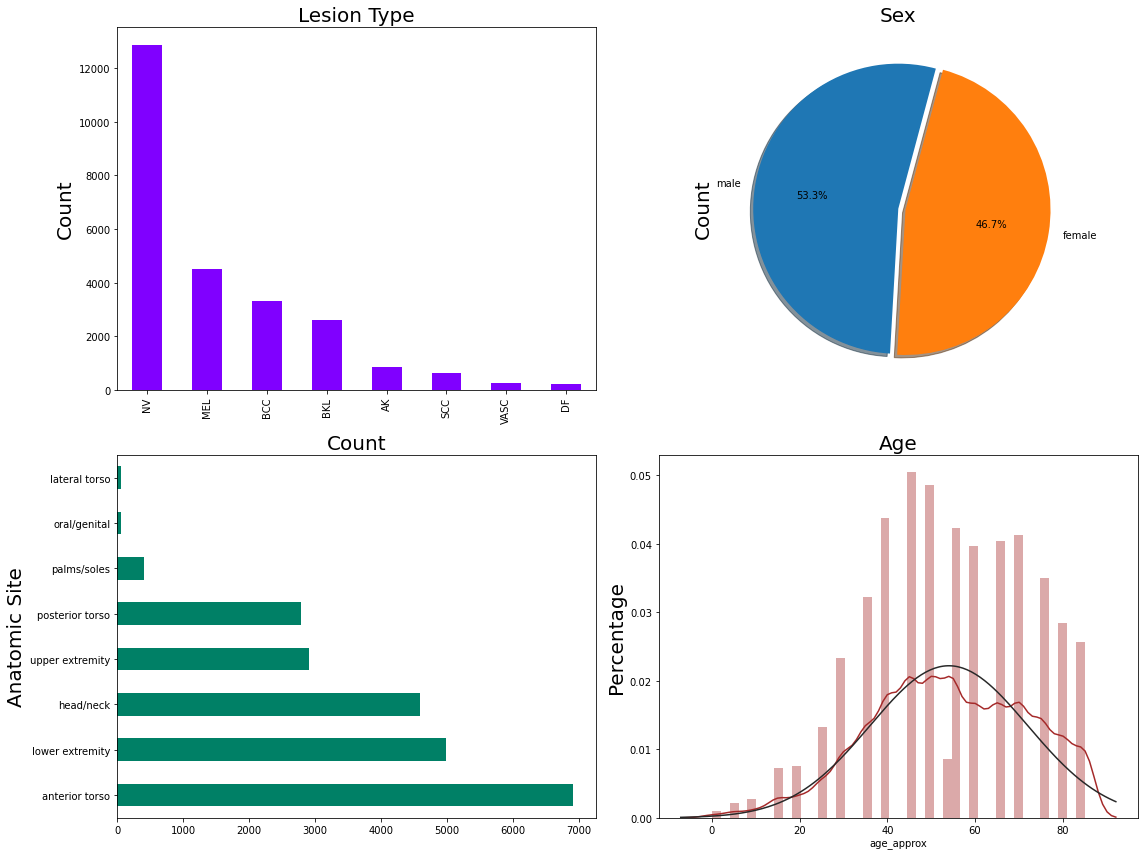

In [2]:
TRAIN_DIR = Path("/home/vasileiosaidonis/ISIC 2019/Training_Images")
TEST_DIR = Path("/home/vasileiosaidonis/ISIC 2019/Test_Images")

num_training_images = len(os.listdir(TRAIN_DIR)) - 1   # Calculates the checkpoint 
num_test_images = len(os.listdir(TEST_DIR)) - 1

print(">> Total training images:  {}   at:   {}".format(num_training_images, TRAIN_DIR))
print(">> Total test images:      {}    at:   {}".format(num_test_images, TEST_DIR))

# Training csv
training_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Training_Metadata.csv")
training_df = pd.DataFrame(training_csv)

# Test csv
test_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Test_Metadata.csv")
test_df = pd.DataFrame(test_csv)

# Add lesion labeling from the GroundTruth csv file to the Training DataFrame 
groundtruth_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Training_GroundTruth.csv")
groundtruth_df = pd.DataFrame(groundtruth_csv)
groundtruth_df["dx"] = groundtruth_df[groundtruth_df.columns[[1,2,3,4,5,6,7,8,9]]].idxmax(axis=1)
df = pd.concat([training_df, groundtruth_df["dx"]], axis=1, join='inner')
df['label'] = pd.Categorical(df['dx']).codes
df['age_approx'].fillna((df['age_approx'].mean()), inplace=True)


#display(training_df.head())
#display(test_df)
display(df.sample(12))
#display(df.isnull().sum())

# Plot values of the dataset
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1, colormap='rainbow')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_title('Lesion Type', fontsize=20);

ax2 = fig.add_subplot(222)
df['sex'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%',
                              shadow=True, startangle=75, explode=(0, 0.05))
ax2.set_ylabel('Count', fontsize=20)
ax2.set_title('Sex', fontsize=20);

ax3 = fig.add_subplot(223)
df['anatom_site_general'].value_counts().plot(kind='barh', colormap='summer')
ax3.set_title('Count', fontsize=20)
ax3.set_ylabel('Anatomic Site', fontsize=20)


ax4 = fig.add_subplot(224)
sample_age = df[pd.notnull(df['age_approx'])]
sn.distplot(sample_age['age_approx'], fit=stats.norm, color='brown');
ax4.set_title('Age', fontsize=20)
ax4.set_ylabel('Percentage', fontsize=20)

plt.tight_layout()
plt.show()

In [3]:
# Split to training and validation dataset
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['dx'])

train_val_splits = pd.concat([df['dx'].value_counts(), df_train['dx'].value_counts(), df_val['dx'].value_counts()],
                              keys=['ALL_IMAGES','___TRAIN___', 'VALIDATION'], axis=1)

train_val_splits.loc[-1] = [len(df), len(df_train), len(df_val)]
train_val_splits.rename(index={-1:'Total:'},inplace=True)
train_val_splits = train_val_splits.style.set_table_attributes('style="font-size: 15px; \
                                                                border: 1.3px solid #000; \
                                                                background-color: #E9E3D6";')
display(train_val_splits)

,ALL_IMAGES,___TRAIN___,VALIDATION
NV,12875,10300,2575
MEL,4522,3618,904
BCC,3323,2658,665
BKL,2624,2099,525
AK,867,694,173
SCC,628,502,126
VASC,253,202,51
DF,239,191,48
Total:,25331,20264,5067


## Copy images to specified folders

In [4]:
# #Copy images to specific class directories 

# print("All images: ", len(glob.glob("/home/vasileiosaidonis/ISIC 2019/Cropped_Training_Images/*")))

# train_images = list(df_train['image'] + ".jpg")
# val_images = list(df_val['image'] + ".jpg")

# for image in tqdm(sorted(glob.glob("/home/vasileiosaidonis/ISIC 2019/Cropped_Training_Images/*.jpg"))):
#     img_name = image[57:]
#     indx = df["image"][df["image"] == img_name[:-4]].index[0]
#     label = df.loc[indx, 'dx']
#     path_from = "/home/vasileiosaidonis/ISIC 2019/Cropped_Training_Images/" + img_name
   
#     if img_name in train_images:
#         path_to = os.path.join("/home/vasileiosaidonis/ISIC 2019/TRAIN_2", label, img_name)
#         shutil.copyfile(path_from, path_to)

#     if img_name in val_images:
#         path_to = os.path.join("/home/vasileiosaidonis/ISIC 2019/VALIDATION_2", label, img_name)
#         shutil.copyfile(path_from, path_to)

## Deal with Class Imbalance

In [5]:
# images_per_class = 7000
# deleted_images = len(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN_2/NV/")) - images_per_class

# # UNDER-sample the NV dataset
# for image in range(deleted_images):
#     rndm_image = random.choice(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN_2/NV/"))
#     os.remove("/home/vasileiosaidonis/ISIC 2019/TRAIN_2/NV/" +rndm_image)

    
# # OVER-sample the other datasets using ImageDataGenerator
# for file in tqdm(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN_2/")):
    
#     #create a new directory with the specific class and load class images
#     os.mkdir("/home/vasileiosaidonis/ISIC 2019/TESTING")
#     os.mkdir("/home/vasileiosaidonis/ISIC 2019/TESTING/"+file)
    
#     for image in os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN_2/"+file):
#         path_from = os.path.join("/home/vasileiosaidonis/ISIC 2019/TRAIN_2",file, image)
#         path_to = os.path.join("/home/vasileiosaidonis/ISIC 2019/TESTING", file, image)
#         shutil.copyfile( path_from, path_to)
        
        
#     find_images_needed = images_per_class - len(os.listdir("/home/vasileiosaidonis/ISIC 2019/TESTING/"+file))
#     #print(find_images_needed)
#     classes_to_avoid = ["UNK","NV"]

#     if file not in classes_to_avoid:
#         batch_size = 50
#         TESTING_PATH = "/home/vasileiosaidonis/ISIC 2019/TESTING/"
#         SAVE_PATH = "/home/vasileiosaidonis/ISIC 2019/TRAIN_2/" + file

#         datagen = ImageDataGenerator(rotation_range=180,
#                                      width_shift_range=0.1,
#                                      height_shift_range=0.1,
#                                      zoom_range=0.1,
#                                      horizontal_flip=True,
#                                      vertical_flip=True,
#                                      fill_mode='nearest')

#         final_datagen = datagen.flow_from_directory(directory=TESTING_PATH,
#                                                     save_to_dir=SAVE_PATH,
#                                                     save_format='jpg',
#                                                     target_size=(224,224),
#                                                     batch_size=batch_size)
    
    
#         num_of_batches = int(np.ceil((find_images_needed)/batch_size))
#         counter = 0
#         for batch in final_datagen:
#             counter +=1
#             if counter > num_of_batches:
#                 break
    
#     # delete directory to re-create for next class
#     shutil.rmtree("/home/vasileiosaidonis/ISIC 2019/TESTING")

In [6]:
print("Size of the classes was:\n")
display(df_train['dx'].value_counts())
print("\nSize of the classes is now:\n")
TOTAL_VAL_IMAGES = len(df_val)
TOTAL_IMAGES = 0
for file in sorted(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN_2/")):
    print(file, len(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN_2/"+file)))
    TOTAL_IMAGES =TOTAL_IMAGES + len(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN_2/"+file))

Size of the classes was:



NV      10300
MEL      3618
BCC      2658
BKL      2099
AK        694
SCC       502
VASC      202
DF        191
Name: dx, dtype: int64


Size of the classes is now:

AK 7040
BCC 7016
BKL 7097
DF 6785
MEL 7068
NV 7000
SCC 6524
UNK 0
VASC 5756


## Preprocess datasets 

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 224 
IMG_WIDTH = 224
EPOCHS = 200
WBT_EPOCHS = 200
RWW_EPOCHS = 200

TRAIN_DIR = "/home/vasileiosaidonis/ISIC 2019/TRAIN_2"
TEST_DIR = "/home/vasileiosaidonis/ISIC 2019/VALIDATION_2"

train_steps = np.ceil(TOTAL_IMAGES / BATCH_SIZE)
val_steps = np.ceil(TOTAL_VAL_IMAGES/ BATCH_SIZE)


datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=60,
                                   width_shift_range=.15,
                                   height_shift_range=.15,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.1)

datagen_val = ImageDataGenerator(rescale=1./255)

train_data_gen = datagen_train.flow_from_directory(directory=TRAIN_DIR,
                                                   batch_size=BATCH_SIZE,                                           
                                                   shuffle=True,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),  # color_mode='grayscale',
                                                   class_mode='categorical')

val_data_gen = datagen_val.flow_from_directory(directory=TEST_DIR,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='categorical')

test_data_gen = datagen_val.flow_from_directory(directory=TEST_DIR,
                                                batch_size=1,                                              
                                                shuffle=False,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='categorical')

Found 54286 images belonging to 9 classes.
Found 5067 images belonging to 9 classes.
Found 5067 images belonging to 9 classes.


# Part 1

### ########################################################


## Threshold Impementation



### ########################################################

## Specify model

In [8]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

import efficientnet.tfkeras as efn

MODEL = efn.EfficientNetB0(input_shape=IMG_SHAPE,
                                          include_top=False,
                                          weights='imagenet') 

model_input = MODEL.input
add_layer = tf.keras.layers.GlobalAveragePooling2D()(MODEL.output)
add_layer = tf.keras.layers.Dropout(0.4)(add_layer)
add_pred = tf.keras.layers.Dense(9, activation='softmax')(add_layer)

model = tf.keras.Model(model_input, add_pred)

#model.summary()

### Train the model

In [9]:
# %%time

# # adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


# metrics = [tf.keras.metrics.CategoricalAccuracy()]


# model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=metrics)


# checkpoint_path = "/home/vasileiosaidonis/ISIC 2019/Model/checkpoints/cp-{epoch}.ckpt"

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   verbose=1,
#                                                   patience=40,
#                                                   restore_best_weights=False)

# def lr_decay(epoch):  
#     if epoch < 8:
#         lr = 1e-5
#     elif epoch >= 8 and epoch < 48:
#         lr = 0.00001*tf.math.exp(0.025 * (8 - epoch))
#     else:
#         lr = 4e-6
       
#     tf.summary.scalar('learning rate', data=lr, step=epoch)    
#     return lr

# lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay)


# history = model.fit_generator(train_data_gen,                                               
#                               steps_per_epoch=TOTAL_IMAGES // BATCH_SIZE,
#                               epochs=EPOCHS,
#                               validation_data=val_data_gen,
#                               validation_steps=TOTAL_VAL_IMAGES // BATCH_SIZE,
#                               callbacks=[cp_callback, early_stopping]
#                               )


# # Save model & history
# model.save("/home/vasileiosaidonis/ISIC 2019/Model/Lesion_B0.h5")
# with open('/home/vasileiosaidonis/ISIC 2019/Model/ModelHistory', 'wb') as h1_file:
#     pickle.dump(history.history, h1_file)
    
# print("\n--------------------")

### Load history and make Predictions

In [10]:
##### Use current history or load from earlier training 
try:
    history
except NameError:
    print(">> Loading model")
    model = tf.keras.models.load_model('./ISIC 2019/Model/Lesion_B0.h5')
    print(">> Loading latest model's History from the file\n")
    with open('ISIC 2019/Model/ModelHistory', 'rb') as h1_file: 
        old_history = load(h1_file)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
 
        acc = old_history['categorical_accuracy']
        val_acc = old_history['val_categorical_accuracy']
        loss = old_history['loss']
        val_loss = old_history['val_loss']
else:
    print("Using data from the trained model\n")
    history_stats = pd.DataFrame(history.history) 
    print(history_stats.tail())
    
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

# Save history to csv file
#history_stats.to_csv("./ISIC 2019/Model/Ef_41.csv", index=False)
   
# Gets index again in case of early stopping    
epochs_range = range(history_stats.index.stop)

# Find the weights with the best validation accuracy
best_weight_simple_model = model
if (history_stats.index.stop == EPOCHS):
    best_checkpoint = "./ISIC 2019/Model/checkpoints/cp-" + str(val_acc.index(max(val_acc))) +".ckpt"
    best_val_accuracy1 = val_acc[val_acc.index(max(val_acc))]
else:
    best_checkpoint = "./ISIC 2019/Model/checkpoints/cp-" + str(val_acc.index(max(val_acc[:-39])))+".ckpt"
    best_val_accuracy1 = val_acc[val_acc.index(max(val_acc[:-39]))]
print("\nBest checkpoint at: {}".format(best_checkpoint))
print("With validation accuracy: {:.5f}\n".format(best_val_accuracy1))
best_weight_simple_model.load_weights(best_checkpoint)

#val_data_gen.reset()
Y_pred = best_weight_simple_model.predict_generator(test_data_gen, steps=len(df_val), verbose=1)
y_pred = Y_pred.argmax(axis=1)


# for i in range(len(df_val))[:30]:
#     print("Label >> {} :  {:.6f} , Predicted label >> {} :  {:.6f}".
#           format(test_data_gen.labels[i],  Y_pred[i][test_data_gen.labels[i]], y_pred[i], Y_pred[i][y_pred[i]]))

>> Loading model
>> Loading latest model's History from the file

        loss  categorical_accuracy  val_loss  val_categorical_accuracy
76  0.071340              0.973827  0.589508                  0.846717
77  0.068164              0.975394  0.610187                  0.846321
78  0.066291              0.976518  0.611247                  0.844937
79  0.064673              0.976665  0.594497                  0.850475
80  0.064977              0.976684  0.593404                  0.846519

Best checkpoint at: ./ISIC 2019/Model/checkpoints/cp-41.ckpt
With validation accuracy: 0.82991

Instructions for updating:
Please use Model.predict, which supports generators.
5067/5067 [==============================] - 68s 13ms/step


### Thresholding the multi-class

In [11]:
# Considering a Confidence approach for classification
# Change the outcome based on certain conditions
# {{ Here if the second best option is the right one change it }}
pop_list = Y_pred.copy()
y2_pred = []
count_wrong, count_changed = 0, 0
for i in range(len(df_val)):
    if test_data_gen.labels[i] != y_pred[i]:
        count_wrong += 1
        first_value = max(pop_list[i])
        #print(first_value)
        pop_list[i][y_pred[i]] = 0
        second_best = pop_list[i].argmax()
        second_value = max(pop_list[i])
        
        # Probability of Wrong label and second True label is less than 5%
        if (second_best == test_data_gen.labels[i]) & (first_value - second_value < 0.05): 
            count_changed += 1
            y2_pred.append(second_best)
        else:
            y2_pred.append(y_pred[i])  
    else:
        y2_pred.append(y_pred[i])

print("\nWrongly labeled: ", count_wrong)
print("Total changed: ", count_changed)


Wrongly labeled:  862
Total changed:  32


### Plots and Confusion matrixes

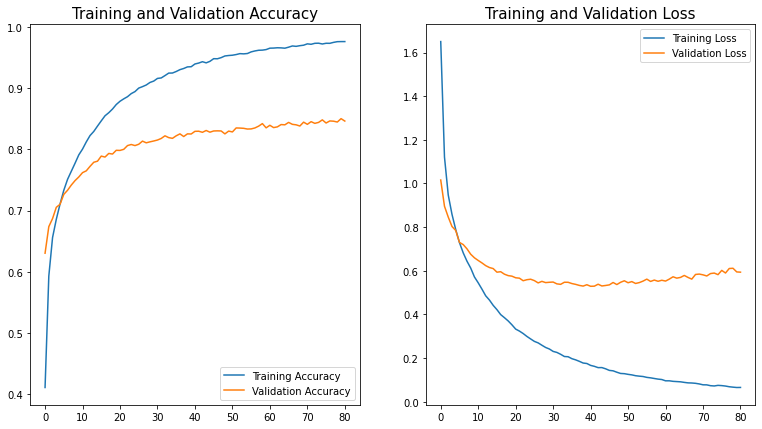

/home/vasileiosaidonis/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Text(570.5454545454544, 0.5, 'True label')

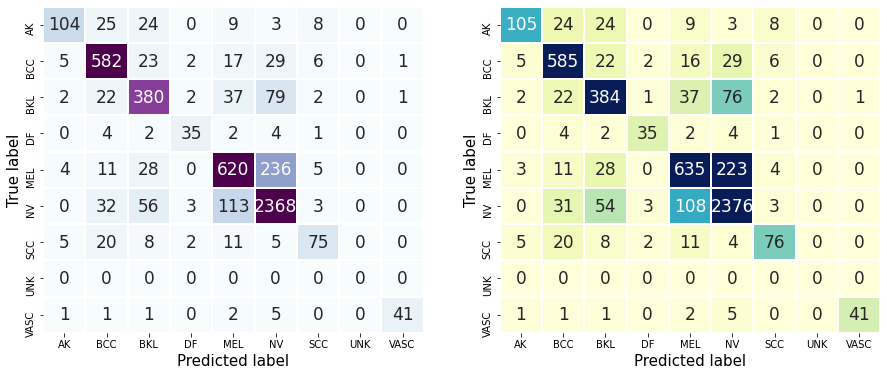

In [12]:
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15, ha='center')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15, ha='center')
plt.show()


tick_labels =['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'] # 
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
CM = confusion_matrix(test_data_gen.classes, y_pred, labels)
CM2 = confusion_matrix(test_data_gen.classes, y2_pred, labels)

FP = CM.sum(axis=0) - np.diag(CM) 
FN = CM.sum(axis=1) - np.diag(CM)
TP = np.diag(CM)
TN = CM.sum() - (FP + FN + TP)
# print("FP {}\nFN {}\nTP {}\nTN {}".format(FP, FN, TP, TN))


plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
#plt.title('Trained Model', fontsize=20, ha='center')
sn.heatmap(CM, annot=True, fmt = "d", cmap="BuPu", cbar=False, vmin=0, vmax=500, xticklabels=tick_labels, yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

plt.subplot(1,2,2)
#plt.title('Model - Top two values < 0.05', fontsize=20, ha='center')
sn.heatmap(CM2, annot=True, fmt = "d", cmap="YlGnBu", cbar= False, vmin=0, vmax=200, xticklabels=tick_labels, yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

### Predicted vs True values

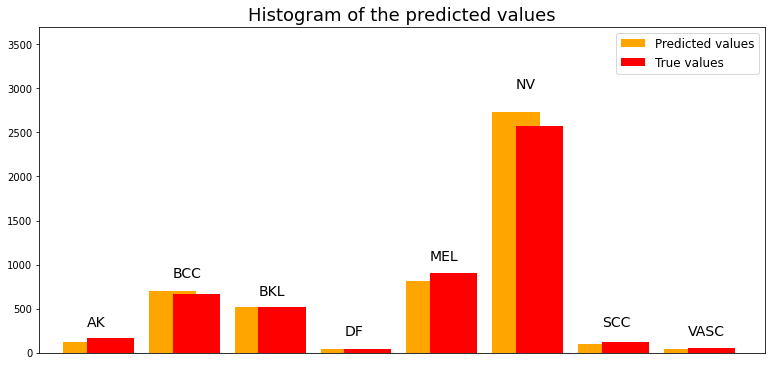

In [13]:
# Histogram of the predicted and true values
label = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'VASC']
height = [300, 850, 650, 200, 1050, 3000, 300, 200]
plt.figure(figsize=(13,6))
plt.hist(y_pred, bins=8, color="orange", align="left", rwidth=0.55, label="Predicted values")
plt.hist(test_data_gen.labels, bins=8, color="red", align="mid", width=0.55, label="True values")
plt.title('Histogram of the predicted values', fontsize=18)
plt.legend(fontsize=12)

for i in range(8):
    plt.annotate(label[i], xy=(i,height[i]), fontsize=14)
ax = plt.gca()
ax.set_ylim([0, 3700])
ax.set_xlim([-0.55, 7.9])
ax.get_xaxis().set_ticks([])
plt.show()

# Part 2

### ########################################################


## Weight Before Training Impementation



### ########################################################

### Specify WBT Model

In [14]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

import efficientnet.tfkeras as efn

WBT_MODEL = efn.EfficientNetB0(input_shape=IMG_SHAPE,
                               include_top=False,
                               weights='imagenet') 

wbt_model_input = WBT_MODEL.input
add_layer = tf.keras.layers.GlobalAveragePooling2D()(WBT_MODEL.output)
add_layer = tf.keras.layers.Dropout(0.4)(add_layer)
add_pred = tf.keras.layers.Dense(9, activation='softmax')(add_layer)

wbt_model = tf.keras.Model(wbt_model_input, add_pred)


class_weights = {0: 1.5,  # AK
                 1: 2.0,  # BCC
                 2: 1.0,  # BKL
                 3: 1.0,  # DF
                 4: 8.2,  # MEL 
                 5: 1.0,  # NV
                 6: 8.2,  # SCC
                 7: 1.3,  # UNK
                 8: 1.5}  # VASC

#model.summary()

### Train WBT Model

In [15]:
# %%time

# ## ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC']


# wbt_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
#                   loss=tf.keras.losses.CategoricalCrossentropy(),
#                   metrics=[tf.keras.metrics.CategoricalAccuracy()])


# wbt_checkpoint_path = "/home/vasileiosaidonis/ISIC 2019/Model/wbt_checkpoints2/cp-{epoch}.ckpt"

# wbt_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=wbt_checkpoint_path,
#                                                      save_weights_only=True,
#                                                      verbose=1)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   verbose=1,
#                                                   patience=40,
#                                                   restore_best_weights=False)

# wbt_history = wbt_model.fit_generator(train_data_gen,                                               
#                                   steps_per_epoch=TOTAL_IMAGES // BATCH_SIZE,
#                                   epochs=WBT_EPOCHS,
#                                   validation_data=val_data_gen,
#                                   class_weight=class_weights,
#                                   validation_steps=TOTAL_VAL_IMAGES // BATCH_SIZE,
#                                   callbacks=[wbt_cp_callback, early_stopping]
#                                   )


# # Save WBT model & history
# model.save("/home/vasileiosaidonis/ISIC 2019/Model/WBT_Lesion_B0_Final.h5")
# with open('/home/vasileiosaidonis/ISIC 2019/Model/WBT_ModelHistory_Final', 'wb') as h1_file:
#     pickle.dump(wbt_history.history, h1_file)
    
# print("\n--------------------")

### Load WBT history and make Predictions

In [16]:
##### Use current history or load from earlier training 
try:
    wbt_history
except NameError:
    print(">> Loading Wbt model")
    wbt_model = tf.keras.models.load_model('./ISIC 2019/Model/WBT_Lesion_B0_Final.h5')
    print(">> Loading latest model's History from the file\n")
    with open('ISIC 2019/Model/WBT_ModelHistory_Final', 'rb') as h2_file: 
        old_history = load(h2_file)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
            
        acc4 = old_history['categorical_accuracy']
        val_acc4 = old_history['val_categorical_accuracy']
        loss4 = old_history['loss']
        val_loss4 = old_history['val_loss']
else:
    print("Using data from the trained Wbt model\n")
    history_stats = pd.DataFrame(wbt_history.history) 
    print(history_stats.tail())
    
    acc4 = wbt_history.history['categorical_accuracy']
    val_acc4 = wbt_history.history['val_categorical_accuracy']
    loss4 = wbt_history.history['loss']
    val_loss4 = wbt_history.history['val_loss']
    
# Save history to csv file
#history_stats.to_csv("./ISIC 2019/Model/Wbt_myweights_73.csv", index=False)

epochs_range = range(history_stats.index.stop)

best_weight_wbt_model = wbt_model
if (history_stats.index.stop == WBT_EPOCHS):
    wbt_best_checkpoint = "./ISIC 2019/Model/wbt_checkpoints/cp-" + str(val_acc4.index(max(val_acc4))) +".ckpt"
    best_val_accuracy2 = val_acc4[val_acc4.index(max(val_acc4))]
else:
    wbt_best_checkpoint = "./ISIC 2019/Model/wbt_checkpoints/cp-" + str(val_acc4.index(max(val_acc4[:-40]))) +".ckpt"
    best_val_accuracy2 = val_acc4[val_acc4.index(max(val_acc4[:-40]))]
print("\nBest checkpoint at: {}".format(wbt_best_checkpoint))
print("With validation accuracy: {:.5f}\n".format(best_val_accuracy2))
best_weight_wbt_model.load_weights(wbt_best_checkpoint)


Y4_pred = best_weight_wbt_model.predict_generator(test_data_gen, steps=len(df_val), verbose=1)
y4_pred = Y4_pred.argmax(axis=1)

>> Loading Wbt model
>> Loading latest model's History from the file

         loss  categorical_accuracy  val_loss  val_categorical_accuracy
108  0.121455              0.972205  0.626515                  0.833465
109  0.122764              0.972168  0.619545                  0.835047
110  0.117095              0.972961  0.647134                  0.831092
111  0.111952              0.974030  0.638350                  0.835443
112  0.110896              0.973090  0.619099                  0.839003

Best checkpoint at: ./ISIC 2019/Model/wbt_checkpoints/cp-72.ckpt
With validation accuracy: 0.82674

5067/5067 [==============================] - 67s 13ms/step


### Plots and Confusion matrixes

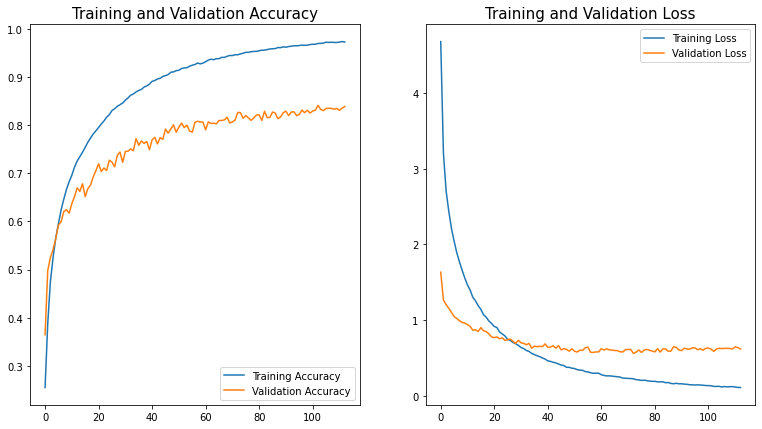

/home/vasileiosaidonis/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'AK'),
 Text(0, 1.5, 'BCC'),
 Text(0, 2.5, 'BKL'),
 Text(0, 3.5, 'DF'),
 Text(0, 4.5, 'MEL'),
 Text(0, 5.5, 'NV'),
 Text(0, 6.5, 'SCC'),
 Text(0, 7.5, 'UNK'),
 Text(0, 8.5, 'VASC')]

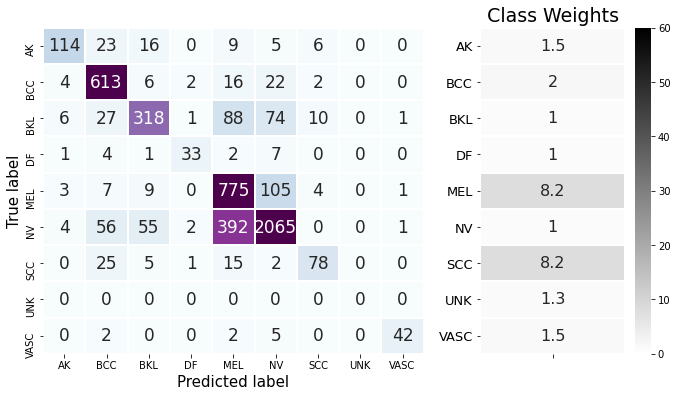

In [17]:
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc4, label='Training Accuracy')
plt.plot(epochs_range, val_acc4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15, ha='center')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss4, label='Training Loss')
plt.plot(epochs_range, val_loss4, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15, ha='center')
plt.show()


tick_labels =  ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'] 
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
CM4 = confusion_matrix(test_data_gen.classes, y4_pred, labels)

FP4 = CM4.sum(axis=0) - np.diag(CM4) 
FN4 = CM4.sum(axis=1) - np.diag(CM4)
TP4 = np.diag(CM4)
TN4 = CM4.sum() - (FP4 + FN4 + TP4)
# print("FP {}\nFN {}\nTP {}\nTN {}".format(FP4, FN4, TP4, TN4))

f = plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
#plt.title('WBT Model', fontsize=20, ha='center')
sn.heatmap(CM4, annot=True, fmt = "d", cmap="BuPu", cbar=False, vmin=0, vmax=500, xticklabels=tick_labels, yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

plt.subplot(1,2,2)
df_w = pd.DataFrame(list(class_weights.items()), index=tick_labels)
df_w.columns = ["Index", ""]
ax = plt.subplot2grid((1, 4), (0, 2))
ax = plt.title('Class Weights', fontsize=19, ha='center')
ax = sn.heatmap(df_w[[""]], cmap="binary", vmin=0, vmax=60, annot=True, linewidths=1, annot_kws={"fontsize":16})
ax.set_yticklabels(tick_labels, rotation = 0, fontsize = 13)

# Part 3

### ########################################################


## RWW crossentropy loss Impementation



### ########################################################

In [18]:
def create_rww_categorical_crossentropy(k, loss_type, fn_weights=None, fp_weights=None, return_weights=False):
 
    """Real-World-Weighted crossentropy between an output tensor and a target tensor.
  
    The loss_types other than rww_categorical_crossentropy reimplement existing 
    functions in Keras but are not as well optimized. 
    These loss_types are usable directly, but, are more useful when calling 
    return_weights=True, which then returns fn and fp weights matrixes of size (k,k). 
    Editing those to reflect real world costs, then passing them back into 
    create_rww_crossentropy with loss_type "rww_crossentropy" is the recommended approach. 

    Example Usage: 

    Suppose you have three classes: cat, dog, and other.
    Cat is one-hot encoded as [1,0,0], dog as [0,1,0], other as [0,0,1]
  
    The the following code increases the incremental penalty of 
    mislabeling a true target 0 (cat) with a false label 1 (dog) at a cost of 99, 
    versus the default of zero. Note that the existing fn_weights also has a 
    default cost of 1 for missing the true target of 1, for a total cost of 
    100 versus the default cost of 1. 
  
    fn_weights, fp_weights = create_rww_categorical_crossentropy(10, "categorical_crossentropy", return_weights=True)
    fp_weights[0, 1] = 99
    loss = create_rww_categorical_crossentropy(10, "rww_crossentropy", fn_weights, fp_weights)
    ... 
  
    The fn and fp weights are easy to reason about. 
  
    fn_weights is [x1, __, __]
                  [__, x2, __]
                  [__, __, x3]
 
    x1 represents the scale of the cost for a fn for cat, x2 for dog, and x3 for other.
  
    This is calculated as fn_weight * log(y_pred). 
  
    In the case of loss_type=categorical_crossentropy, 
    x1, x2, and x3 all equal the value one. 
    All elements not on the main axis must equal zero. 
  
    Note that fn_weights could have been represented as a vector, 
    not a matrix, however, we use a matrix to keep symmetry with 
    fp_weights, and, to prepare for 
    multi-label classification. 
    ...

    fp_weights is concerned with the costs of the fps from the other classes. 

    fp_weights of [__, x1, x2]
                  [x3, __, x4]
                  [x5, x6, __]
 
    x1 represents the cost of predicting 1 for dog, when it should be 0 for cat. 
    x2 represents predicting 2 for other, when the target is 0 for cat. 
    x3 represents predicing 0 for cat, when the target is 1 for dog.
    etc. 
  
    Args:
      * k: 2 or more for number of categories, including "other". 
      * loss_type: "categorical_crossentropy" to initialize to 
        standard softmax_crossentropy behavior, 
        or "weighted_categorical_crossentropy" for standard behavior, or, 
        or "rww_crossentropy" for full weight matrix of all possible fn/fp combinations. 
      * fn_weights: a numpy array of shape (k,k). The main diagonal can
        contain non-zero values; all other values must be zero. 
      * fp_weights: a numpy array of shape (k,k) to define specific combinations 
        of false positive. The main diag should be zeros. 
      * return_weights: If False (default), returns cost function. If True, 
        returns fn and fp weights as np.array. 
    Returns:
      * retval: Loss function for use Keras.model.fit, or if return_weights
        arg is True, the fn_weights and fp_weights matrixes. 
    """

    full_fn_weights = None
    full_fp_weights = None

    anti_eye = np.ones((k,k)) - np.eye(k)
    
    if (loss_type=="categorical_crossentropy"):
        full_fn_weights = np.identity((k))
        full_fp_weights = np.zeros((k, k)) # Softmax crossentropy ignores fp.

    elif(loss_type=="weighted_categorical_crossentropy"):
        full_fn_weights = np.eye(k) * fn_weights
        full_fp_weights = np.zeros((k, k)) # softmax crossentropy ignores fp
    
    elif(loss_type=="rww_crossentropy"):
        assert not np.count_nonzero(fn_weights * anti_eye)
        assert not np.count_nonzero(fp_weights * np.eye(k))

        full_fn_weights = fn_weights
        # Novel piece: allow any combination of fp.
        full_fp_weights = fp_weights
    
    else:
        raise Exception("unknown loss_type: " + str(loss_type))
   
    fn_wt = K.constant(full_fn_weights) # (k,k), always sparse along main diag. 
    fp_wt = K.constant(full_fp_weights) # (k,k), always dense except main diag. 

    def loss_function(target, output):
        output = K.clip(output, K.epsilon(), 1 - K.epsilon()) 
    
        logs = K.log(output) # shape (m, k), dense. 1 is good. 
        logs_1_sub = K.log(1-output) # shape (m, k), dense. 0 is good. 

        m_full_fn_weights = K.dot(target, fn_wt) # (m,k) . (k, k)
        m_full_fp_weights = K.dot(target, fp_wt) # (m,k) . (k, k)

        return - K.mean(m_full_fn_weights * logs + 
                        m_full_fp_weights * logs_1_sub)
  
    if (return_weights):
        return full_fn_weights, full_fp_weights
    else:
        return loss_function

In [19]:
# # Example of categorical_crossentropy. Class behavior. 
# fn_weights, fp_weights = create_rww_categorical_crossentropy(5, 'categorical_crossentropy', return_weights=True)
# print("softmax cross entropy weights. k=5 classes. Expected output: fn: ones, fp:zeros. ")
# print (fn_weights)
# print (fp_weights)

# # Example of weighted single-label categorical crossentropy. 
# fn_weights, fp_weights = create_rww_categorical_crossentropy(5, 'weighted_categorical_crossentropy', np.array([1,2,3,4,5]), return_weights=True)
# print("weighted softmax crossentropy. k=5 classes. Expected output: fn: weights, fp: zeros. ")
# print (fn_weights)
# print (fp_weights)


# Example of full weighted multi-label categorical crossentropy
fn_weights, fp_weights = create_rww_categorical_crossentropy(9, "categorical_crossentropy", return_weights=True)
# First 2 lines
fp_weights[0,1] = fp_weights[1,0] = fp_weights[0,8] = fp_weights[1,0] = fp_weights[1,1] = fp_weights[1,8] = 0
fp_weights[0,4] = fp_weights[0,6] = fp_weights[0,7] = fp_weights[1,4] = fp_weights[1,6] = fp_weights[1,7] = 10
fp_weights[0,2] = fp_weights[0,3] = fp_weights[0,5] = 20
fp_weights[1,2] = fp_weights[1,3] = fp_weights[1,5] = 30

# Line 2-3 and 5
fp_weights[2,2] = fp_weights[2,3] = fp_weights[2,5] = fp_weights[3,2] = fp_weights[3,3] = fp_weights[3,5] = 0
fp_weights[5,2] = fp_weights[5,3] = fp_weights[5,5] = 0
fp_weights[2,0] = fp_weights[2,1] = fp_weights[2,4] = fp_weights[2,6] = fp_weights[2,7] = fp_weights[2,8] = 10
fp_weights[3,0] = fp_weights[3,1] = fp_weights[3,4] = fp_weights[3,6] = fp_weights[3,7] = fp_weights[3,8] = 10
fp_weights[5,0] = fp_weights[5,1] = fp_weights[5,4] = fp_weights[5,6] = fp_weights[5,7] = fp_weights[5,8] = 10


# Line 4 and 6
fp_weights[4,0] = fp_weights[4,1] = fp_weights[6,0] = fp_weights[6,1] = 10
fp_weights[4,7] = fp_weights[4,8] = fp_weights[6,7] = fp_weights[6,8] = 10
fp_weights[4,2] = fp_weights[4,3] = fp_weights[4,5] = fp_weights[6,2] = fp_weights[6,3] = fp_weights[6,5] =150


# Line 7-8
fp_weights[7,0] = fp_weights[7,1] = fp_weights[7,2] = fp_weights[7,3] = 10
fp_weights[7,4] = fp_weights[7,5] = fp_weights[7,6] = fp_weights[7,8] = 10
fp_weights[7,7]  = 0

fp_weights[8,0] = fp_weights[8,1] = fp_weights[8,8] = 0
fp_weights[8,4] = fp_weights[8,6] = fp_weights[8,7] = 10
fp_weights[8,2] = fp_weights[8,3] = fp_weights[8,5] = 20


rww_loss = create_rww_categorical_crossentropy(9, "rww_crossentropy", fn_weights, fp_weights)
print (fn_weights)
print (fp_weights)
print(rww_loss)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[  0.   0.  20.  20.  10.  20.  10.  10.   0.]
 [  0.   0.  30.  30.  10.  30.  10.  10.   0.]
 [ 10.  10.   0.   0.  10.   0.  10.  10.  10.]
 [ 10.  10.   0.   0.  10.   0.  10.  10.  10.]
 [ 10.  10. 150. 150.   0. 150.   0.  10.  10.]
 [ 10.  10.   0.   0.  10.   0.  10.  10.  10.]
 [ 10.  10. 150. 150.   0. 150.   0.  10.  10.]
 [ 10.  10.  10.  10.  10.  10.  10.   0.  10.]
 [  0.   0.  20.  20.  10.  20.  10.  10.   0.]]
<function create_rww_categorical_crossentropy.<locals>.loss_function at 0x7f219cc72378>


### Specify RWW Model

In [20]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

import efficientnet.tfkeras as efn

RWW_MODEL = efn.EfficientNetB0(input_shape=IMG_SHAPE,
                               include_top=False,
                               weights='imagenet') 

rww_model_input = RWW_MODEL.input
add_layer = tf.keras.layers.GlobalAveragePooling2D()(RWW_MODEL.output)
#add_layer = tf.keras.layers.Dropout(0.4)(add_layer)
add_pred = tf.keras.layers.Dense(9, activation='softmax')(add_layer)

rww_model = tf.keras.Model(rww_model_input, add_pred)

#model.summary()

### Train RWW model

In [21]:
# %%time

# rww_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3, momentum=0.0, nesterov=False, name='SGD'), # optimizer=tf.keras.optimizers.Adam(lr=5e-6),                                                           
#                   loss=rww_loss,                                          
#                   metrics=['accuracy'])

# rww_checkpoint_path = "/home/vasileiosaidonis/ISIC 2019/Model/rww_checkpoints7/cp-{epoch}.ckpt"

# # Create a callback that saves the model's weights
# rww_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=rww_checkpoint_path,
#                                                      save_weights_only=True,
#                                                      verbose=1,
#                                                      period=1)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   verbose=1,
#                                                   patience=40,  
#                                                   restore_best_weights=False)


# rww_history = rww_model.fit_generator(train_data_gen,                                               
#                                       steps_per_epoch=TOTAL_IMAGES // BATCH_SIZE,
#                                       epochs=RWW_EPOCHS,
#                                       validation_data=val_data_gen,
#                                       validation_steps=TOTAL_VAL_IMAGES // BATCH_SIZE,
#                                       callbacks=[rww_cp_callback, early_stopping]
#                                       )


# # Save model & history
# rww_model.save("/home/vasileiosaidonis/ISIC 2019/Model/RWW_Lesion_B0_Final2.h5")
# with open('/home/vasileiosaidonis/ISIC 2019/Model/RWW_ModelHistory_Final2', 'wb') as h2_file:
#     pickle.dump(rww_history.history, h2_file)
    
# print("\n--------------------")

### Load RWW history and make Predictions

In [22]:
##### Use current history or load from earlier training 
try:
    rww_history
except NameError:
    print(">> Loading RWW model")
    rww_model = tf.keras.models.load_model('./ISIC 2019/Model/RWW_Lesion_B0_Final.h5',
                                          custom_objects={'loss_function': create_rww_categorical_crossentropy(9, "rww_crossentropy", fn_weights, fp_weights)})
    print(">> Loading latest model's History from the file\n")
    with open('ISIC 2019/Model/RWW_ModelHistory_Final', 'rb') as h2_file: 
        old_history = load(h2_file)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
            
        acc3 = old_history['accuracy']
        val_acc3 = old_history['val_accuracy']
        loss3 = old_history['loss']
        val_loss3 = old_history['val_loss']
else:
    print("Using data from the trained RWW model\n")
    history_stats = pd.DataFrame(rww_history.history) 
    print(history_stats.tail())

    acc3 = rww_history.history['accuracy']
    val_acc3 = rww_history.history['val_accuracy']
    loss3 = rww_history.history['loss']
    val_loss3 = rww_history.history['val_loss']
    
# Save history to csv file
#history_stats.to_csv("./ISIC 2019/Model/Rww_myweights_51.csv", index=False)

epochs_range = range(history_stats.index.stop)

best_weight_rww_model = rww_model
if (history_stats.index.stop == RWW_EPOCHS):
    rww_best_checkpoint = "./ISIC 2019/Model/rww_checkpoints6/cp-" + str(val_acc3.index(max(val_acc3))) +".ckpt"
    best_val_accuracy3 = val_acc3[val_acc3.index(max(val_acc3))]
else:
    rww_best_checkpoint = "./ISIC 2019/Model/rww_checkpoints6/cp-" + str(val_acc3.index(val_acc3[-41])) +".ckpt"
    best_val_accuracy3 = val_acc3[val_acc3.index(val_acc3[-41])]
print("\nBest checkpoint at: {}".format(rww_best_checkpoint))
print("With validation accuracy: {:.5f}\n".format(best_val_accuracy3))
best_weight_rww_model.load_weights(rww_best_checkpoint)


Y3_pred = best_weight_rww_model.predict_generator(test_data_gen, steps=len(df_val), verbose=1)
y3_pred = Y3_pred.argmax(axis=1)

>> Loading RWW model
>> Loading latest model's History from the file

        loss  accuracy  val_loss  val_accuracy
73  0.278850  0.817525  0.975911      0.709850
74  0.282273  0.817507  1.126318      0.728639
75  0.277476  0.820456  1.063031      0.719343
76  0.278579  0.820898  1.295810      0.730617
77  0.271629  0.822667  1.057004      0.720728

Best checkpoint at: ./ISIC 2019/Model/rww_checkpoints6/cp-37.ckpt
With validation accuracy: 0.59612

5067/5067 [==============================] - 68s 13ms/step


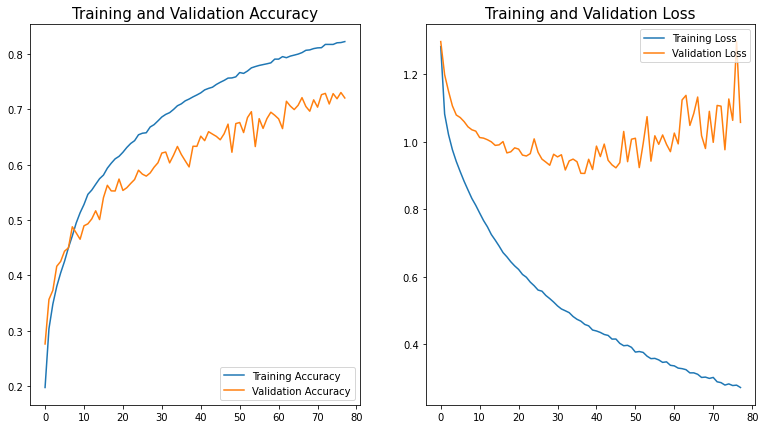

/home/vasileiosaidonis/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


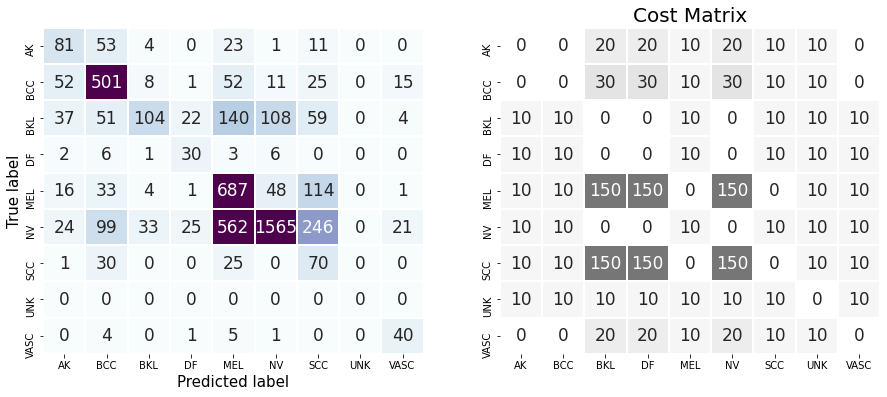

In [23]:
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15, ha='center')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15, ha='center')
plt.show()

tick_labels =  ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'] 
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
CM3 =  confusion_matrix(test_data_gen.classes, y3_pred, labels)

FP3 = CM3.sum(axis=0) - np.diag(CM3) 
FN3 = CM3.sum(axis=1) - np.diag(CM3)
TP3 = np.diag(CM3)
TN3 = CM3.sum() - (FP3 + FN3 + TP3)
# print("FP {}\nFN {}\nTP {}\nTN {}".format(FP4, FN4, TP4, TN4))

plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
#plt.title('RWW Model', fontsize=20, ha='center')
sn.heatmap(CM3, annot=True, fmt = "d", cmap="BuPu", cbar=False, vmin=0, vmax=500, xticklabels=tick_labels, yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

plt.subplot(1,2,2)
plt.title('Cost Matrix', fontsize=20, ha='center')
df_x = pd.DataFrame(fp_weights).astype(int)
ax = sn.heatmap(df_x, annot=True, fmt = "d", cmap="binary", vmin=0, vmax = 280, cbar=False, xticklabels=tick_labels, yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":17})

### Comparisons & costs for the given images

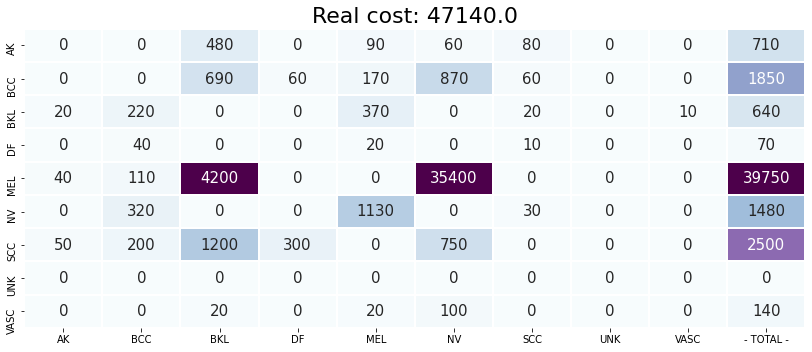

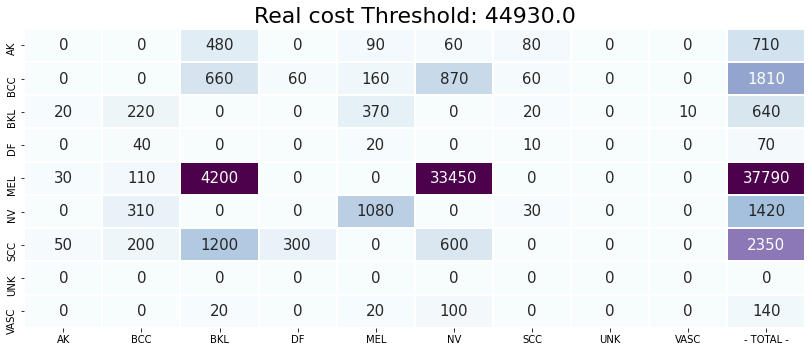

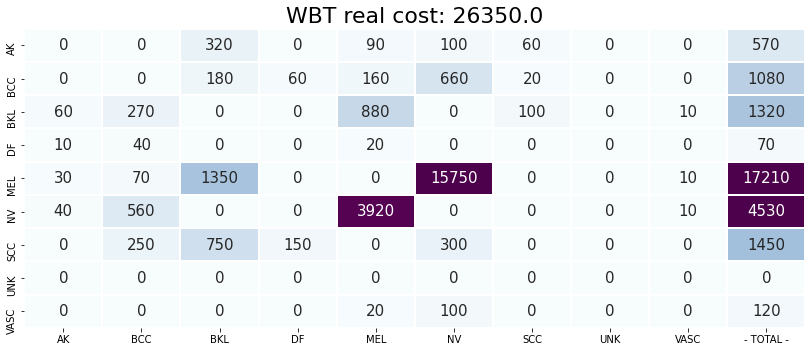

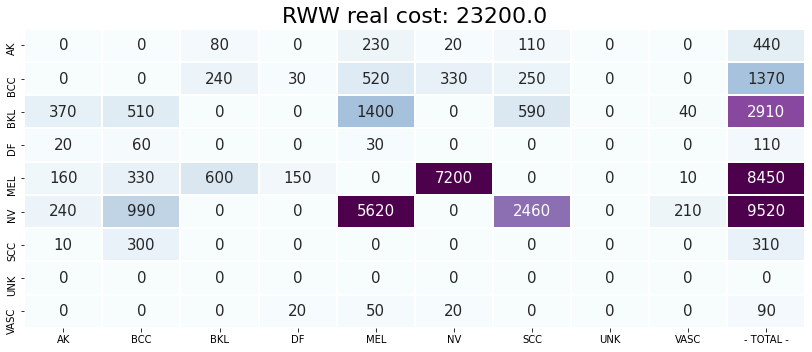

In [24]:
def make_df(CM):
    cost_matrix = [[0 for x in range(9)] for y in range(9)]
    row = []
    for i in range(9):
        nrow = 0
        for j in range(9):
            cost_matrix[i][j] = CM[i,j]*fp_weights[i,j]
            nrow += cost_matrix[i][j]
        row.append(nrow)
    n_df = pd.DataFrame(cost_matrix)
    n_df["Class Cost"] = row

    return n_df, row

plt.figure(figsize = (14,5.5))
plt.title("Real cost: "+str(sum(make_df(CM)[1])), fontsize=22, ha='center')
ax1 = sn.heatmap(make_df(CM)[0], annot=True, fmt="g", cmap="BuPu", cbar=False, vmin=0, vmax=4000, 
                 xticklabels=tick_labels+["- TOTAL -"], yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":15})

plt.figure(figsize = (14,5.5))
plt.title("Real cost Threshold: "+str(sum(make_df(CM2)[1])), fontsize=22, ha='center')
ax1 = sn.heatmap(make_df(CM2)[0], annot=True, fmt="g", cmap="BuPu", cbar=False, vmin=0, vmax=4000, 
                 xticklabels=tick_labels+["- TOTAL -"], yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":15})

plt.figure(figsize = (14,5.5))
plt.title("WBT real cost: "+str(sum(make_df(CM4)[1])), fontsize=22, ha='center')
ax = sn.heatmap(make_df(CM4)[0], annot=True, fmt="g", cmap="BuPu", cbar=False, vmin=0, vmax=4000,
                xticklabels=tick_labels+["- TOTAL -"], yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":15})

plt.figure(figsize = (14,5.5))
plt.title("RWW real cost: "+str(sum(make_df(CM3)[1])), fontsize=22, ha='center')
ax1 = sn.heatmap(make_df(CM3)[0], annot=True, fmt="g", cmap="BuPu", cbar=False, vmin=0, vmax=4000,
                 xticklabels=tick_labels+["- TOTAL -"], yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":15})

### Statistics for each model

In [25]:
import warnings
warnings.filterwarnings('ignore')

def sensitivity(tp, fn):
    output = []
    for i in range(len(tp)):
        output.append(str(round(tp[i] / (tp[i] + fn[i]), 3)))
    return output

def specificity(tn, fp):
    output = []
    for i in range(len(tn)):
        output.append(str(round(tn[i] / (tn[i] + fp[i]), 3)))
    return output

def fpr(fp, tn):
    output = []
    for i in range(len(fp)):
        output.append(str(round(fp[i] / (tn[i] + fp[i]), 3)))
    return output

def f1_score(tp, fp, fn):
    output = []
    for i in range(len(tp)):
        output.append(str(round(2*tp[i] / (2*tp[i] + fp[i] + fn[i]), 3)))
    return output


def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()        
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
    
# print("For Normal Model:\n        Accuracy: {:.3f}\n        Sensitivity: {}\n        Specificity: {}\n        F1-score: {}\n        Cost: {}\n"
#       .format(best_val_accuracy1, sensitivity(TP,FN), specificity(TN,FP), f1_score(TP, FP, FN), sum(make_df(CM)[1])))
# print("For WBT Model:\n        Accuracy: {:.3f}\n        Sensitivity: {}\n        Specificity: {}\n        F1-score: {}\n        Cost: {}\n"
#       .format(best_val_accuracy2, sensitivity(TP4,FN4), specificity(TN4,FP4), f1_score(TP4, FP4, FN4), sum(make_df(CM4)[1])))
# print("For RWW Model:\n        Accuracy: {:.3f}\n        Sensitivity: {}\n        Specificity: {}\n        F1-score: {}\n        Cost: {}\n"
#       .format(best_val_accuracy3, sensitivity(TP3,FN3), specificity(TN3,FP3), f1_score(TP3, FP3, FN3), sum(make_df(CM3)[1])))

# DataFrame for Statistics
data = {'FP Rate': fpr(FP, TN),
        'F1 score': f1_score(TP, FP, FN),
        'Sensitivity': sensitivity(TP, FN),
        'Specificity': specificity(TN, FP),
        'FN': FN,
        'FP': FP,
        'Real Cost': [int(value) for value in make_df(CM)[1]]
        }
data2 = {'FP Rate': fpr(FP4, TN4),
        'F1 score': f1_score(TP4, FP4, FN4),
        'Sensitivity': sensitivity(TP4, FN4),
        'Specificity': specificity(TN4, FP4),
        'FN': FN4,
        'FP': FP4,
        'Real Cost': [int(value) for value in make_df(CM4)[1]]
        }

data3 = {'FP Rate': fpr(FP3, TN3),
        'F1 score': f1_score(TP3, FP3, FN3),
        'Sensitivity': sensitivity(TP3, FN3),
        'Specificity': specificity(TN3, FP3),
        'FN': FN3,
        'FP': FP3,
        'Real Cost': [int(value) for value in make_df(CM3)[1]]
        }

df1 = pd.DataFrame(data, columns = ['FP Rate', 'F1 score', 'Sensitivity', 'Specificity', 'FN', 'FP', 'Real Cost'],
                  index=['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'])

df2 = pd.DataFrame(data2, columns = ['FP Rate', 'F1 score', 'Sensitivity', 'Specificity', 'FN', 'FP', 'Real Cost'],
                  index=['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'])

df3 = pd.DataFrame(data3, columns = ['FP Rate', 'F1 score', 'Sensitivity', 'Specificity', 'FN', 'FP', 'Real Cost'],
                  index=['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'])

print("\033[1m  \033[4m                        SIMPLE MODEL                                                  WBT MODEL"\
      "                                                 RWW MODEL                      \033[0m")
display_side_by_side(df1,df2,df3)

                          SIMPLE MODEL                                                  WBT MODEL                                                 RWW MODEL                      


,FP Rate,F1 score,Sensitivity,Specificity,FN,FP,Real Cost
AK,0.003,0.707,0.601,0.997,69,17,710
BCC,0.026,0.855,0.875,0.974,83,115,1850
BKL,0.031,0.726,0.724,0.969,145,142,640
DF,0.002,0.761,0.729,0.998,13,9,70
MEL,0.046,0.723,0.686,0.954,284,191,39750
NV,0.145,0.893,0.92,0.855,207,361,1480
SCC,0.005,0.664,0.595,0.995,51,25,2500
UNK,0.0,nan,nan,1.0,0,0,0
VASC,0.0,0.872,0.804,1.0,10,2,140
,FP Rate,F1 score,Sensitivity,Specificity,FN,FP,Real Cost


### Cost based on the probabilistic prediction for one image

---------------------------------
 Example of the Cost calculation 
--------------------------------- 


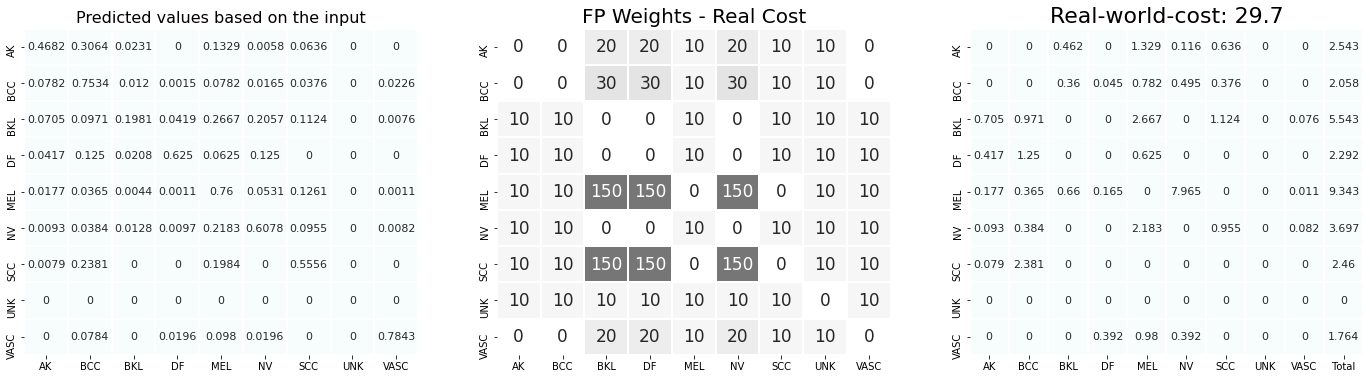

In [26]:
# if i have 100 AKs, 3000 BCCs, 500 MEL and 40 VASC
# class_list = [AK, BCC, BKL, DF, MEL, NV, SCC, UNK, VASC]

class_list = [100, 3000, 0, 0, 500, 0, 0, 0, 40]

df_values = pd.DataFrame(class_list, columns = ['Amount'],
                  index=['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'])
# display(df_values)

def find_amount(CM, cl_l):
    probability_table = []
    for i in range(len(CM)):
        if i == 7:
            probability_table.append([0 for x in range(9)])
        else:
            probability_table.append(np.round_(CM[i] / sum(CM[i]), 4))
    
    values_table, sum_row = [], []
    for i in range(len(class_list)):
        if i != 7:
            values_table.append(np.floor(probability_table[i]*cl_l[i]))
            # adding the values that floor excluded as correctly classified
            difference = class_list[i] - sum(values_table[-1])
            values_table[-1][i] += difference
        else:
            values_table.append([0 for x in range(9)])        
    
    return values_table, probability_table


def custom_values_cost(pv):
    cost_matrix = [[0 for x in range(9)] for y in range(9)]
    row = []
    for i in range(9):
        nrow = 0
        for j in range(9):
            cost_matrix[i][j] = pv[i][j]*fp_weights[i,j]
            nrow += cost_matrix[i][j]
        row.append(nrow)
    n_df = pd.DataFrame(cost_matrix)
    n_df["Class Cost"] = row

    return n_df, row


# Firstly, find the ammount of lesions for each class based on the confustion matrix
# by calling the find_ammount() function
# Then, call the custom_values_cost() function by specifying the predicted values and get the real cost
# Probability table is also specified
predicted_values = find_amount(CM3, class_list)[0]
probability_table = find_amount(CM3, class_list)[1]

df_pv = pd.DataFrame(predicted_values)
df_pt = pd.DataFrame(probability_table)
# print(df_pt)

# find cost based on the predicted values table
cvc = custom_values_cost(probability_table)

print("---------------------------------")
print("\033[1m Example of the Cost calculation \n--------------------------------- \033[0m")

plt.figure(figsize = (24,6))
plt.subplot(1,3,1)
plt.title("Predicted values based on the input", fontsize=16)
sn.heatmap(probability_table, annot=True, cbar=False, fmt="g", cmap="BuPu", vmin=0, vmax=500, 
                 xticklabels=tick_labels, yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":11})

plt.subplot(1,3,2)
plt.title('FP Weights - Real Cost', fontsize=20, ha='center')
df_x = pd.DataFrame(fp_weights).astype(int)
ax = sn.heatmap(df_x, annot=True, fmt = "d", cmap="binary", vmin=0, vmax = 280, cbar=False,
                     xticklabels=tick_labels, yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":17})

plt.subplot(1,3,3)
plt.title("Real-world-cost: "+str(round(sum(cvc[1]),5)), fontsize=22, ha='center')
sn.heatmap(cvc[0], annot=True, fmt="g", cmap="BuPu", cbar=False, vmin=0, vmax=5000, 
                 xticklabels=tick_labels+[" Total "], yticklabels=tick_labels, linewidths=1, annot_kws={"fontsize":11})

### Overall cost for each method

In [27]:
def row_color(s, axis=0):
    col = []
    for i in range(len(final_data['Max Output'])):
        if (i==8):
            col.append('background-color: #ECECEC')
        else:
            col.append('background-color: white')
    return col

# Get probability table for each method
prob_table_CM = find_amount(CM, class_list)[1]
prob_table_CM2 = find_amount(CM2, class_list)[1]
prob_table_CM3 = find_amount(CM3, class_list)[1]
prob_table_CM4 = find_amount(CM4, class_list)[1]

# Get the dataframe of the cost * probability for one image
cvc_1 = custom_values_cost(prob_table_CM)
cvc_2 = custom_values_cost(prob_table_CM2)
cvc_3 = custom_values_cost(prob_table_CM3)
cvc_4 = custom_values_cost(prob_table_CM4)

# Specify variables for each method, make df a list
c1 = cvc_1[0]["Class Cost"].tolist()
c2 = cvc_2[0]["Class Cost"].tolist()
c3 = cvc_3[0]["Class Cost"].tolist()
c4 = cvc_4[0]["Class Cost"].tolist()

final_data = {'Max Output': c1,
              'Top-2 < 0.05': c2,
              'Max Output  ': c4,
              'Max Output ': c3,
             }

cost_df = pd.DataFrame(final_data, columns = ['Max Output', 'Top-2 < 0.05', 'Max Output  ', 'Max Output '],
                  index=['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'])

cost_df.drop('UNK', inplace=True)
cost_df.loc[-1] = [np.sum(cost_df['Max Output']), np.sum(cost_df['Top-2 < 0.05']), np.sum(cost_df['Max Output  ']), np.sum(cost_df['Max Output '])]
cost_df.rename(index={-1:'Total:'}, inplace=True)

cost_df = cost_df.style.set_table_attributes('style="font-size: 18px; \
                                              border: 3px solid #000;"')

cost_df = cost_df.set_properties(**{
    'text-align': 'center',
    'font-size': '14pt',
    'border': '1px solid #000'
})
cost_df.format({'Max Output': '{:.3f}'.format,
                'Top-2 < 0.05': '{:.3f}'.format,
                'Max Output  ': '{:.3f}'.format,
                'Max Output ': '{:.3f}'.format})

cost_df.apply(row_color)
print("\n"*2)
display(cost_df)

,Max Output,Top-2 < 0.05,Max Output,Max Output
AK,4.102,4.102,3.295,2.543
BCC,2.782,2.722,1.624,2.058
BKL,1.219,1.219,2.513,5.543
DF,1.458,1.458,1.458,2.292
MEL,43.981,41.810,19.051,9.343
NV,0.575,0.551,1.759,3.697
SCC,19.849,18.649,11.509,2.460
VASC,2.744,2.744,2.352,1.764
Total:,76.710,73.255,43.561,29.700
